In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree

import SweetSpotPrediction as ssp

# Test Case read data

In [2]:
# File paths with corresponding map names
files_names = {'Data\\thickness\\thickness': 'Thickness'
         , 'Data\\case2exp\\averagentg': 'AvgNTG'
         , 'Data\\case2exp\\avgperm': 'AvgPerm'
         , 'Data\\case2exp\\avgporo': 'AvgPoro'
         , 'Data\\case2exp\\netperm': 'NetPerm'
               
         , 'Data\\case2exp\\sweetspotsfull': 'SweetSpot'
              }

# Read map files
dfs = []
spacing = 50 # map grid cell dimension
for key in files_names:
    df = pd.read_csv(key, delimiter=' ', comment='#', names=['XPos', 'YPos', files_names[key], 'c1', 'c2'])
    df.drop(columns=['c1', 'c2'], inplace=True)
    df_reg = ssp.make_regular(df, files_names[key], spacing)
    df_reg.set_index(['XPos','YPos'], inplace=True)
    dfs = dfs + [df_reg]

# Merge dataframes
df = pd.concat(dfs, axis='columns', join='inner').reset_index()

In [3]:
features = [
    #'XPos', # propbably dont want these as features
    #'YPos', # propbably dont want these as features
    'Thickness',
    'AvgNTG',
    'AvgPerm',
    'AvgPoro',
    'NetPerm',

]

label_clf = 'SweetSpot' 

# Data cleaning

In [4]:
# Functions to drop values less than zero or greater than one

def drop_neg(x):
    if x < 0:
        return np.nan
    else:
        return x

def drop_gt1(x):
    if x > 1:
        return np.nan
    else:
        return x
    
def zero_to_one(x):
    if x < 0.2:
        return 0
    else:
        return 1

In [5]:
def clean_columns(df):

    # Clean dataframe according to specified columns to remove negatives or greater than one
    df_clean = df.copy()

    cols_remove_negs = set(df_clean.columns) - {'XPos', 'YPos', 'SweetSpot'}
    cols_remove_gt1 = {'AvgNTG', 'WellProbability'}
    cols_limit_zero_to_one = { 'SweetSpot'}


    for col in df_clean.columns:
        if col in cols_remove_negs:
            df_clean[col] = df_clean[col].apply(drop_neg)
        if col in cols_remove_gt1:
            df_clean[col] = df_clean[col].apply(drop_gt1)
        if col in cols_limit_zero_to_one:
            df_clean[col] = df_clean[col].apply(zero_to_one)
    df_clean.dropna(inplace=True)
    return df_clean

In [6]:
df_clean = clean_columns(df)

In [7]:
df_clean.SweetSpot = df_clean.SweetSpot.fillna(0).round().astype('int64')

# Goal: Sweet Spots Test Case

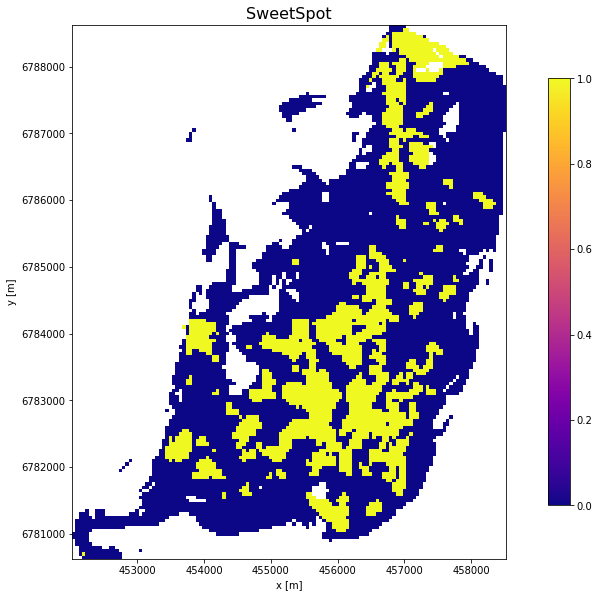

In [8]:
ssp.plot_map(df_clean, 'SweetSpot', dtype='cat')

# Normalization and other preprocessing

In [21]:
#%store -r preprocessing

#X_test = preprocessing.transform(df_clean[features])

preprocessing = StandardScaler()
X_test = preprocessing.fit_transform(df_clean[features])

y_test = df_clean[label_clf]
X_test[-5:]

array([[-0.94421613,  1.0147854 ,  0.45399467,  1.47309704, -0.16247769],
       [-0.98823083,  1.00691244,  0.39411497,  1.26399053, -0.24399142],
       [-1.02150535,  0.73120866,  0.40718245,  1.2111984 , -0.31772138],
       [-1.04416812,  0.37248661,  0.50934883,  1.40440653, -0.13466339],
       [-1.07539416,  0.09592339,  0.56136898,  1.61785664, -0.11700979]])

# Load Model and make prediction

In [22]:
from sklearn.naive_bayes import GaussianNB

%store -r model

y_pred_test = model.predict(X_test)
df_clean['prediction'] = model.predict(preprocessing.transform(df_clean[features]))
#df_clean['prediction'] = y_pred_test

# Model Scores

In [23]:
from sklearn import metrics

# Model Precision: number of positive predictions divided by the total number of positive class values predicted.
print("Precision: {:.3f}".format(metrics.precision_score(y_test, y_pred_test)))

# Model Recall: the number of positive predictions divided by the number of positive class values in the data
print("Recall: {:.3f}".format(metrics.recall_score(y_test, y_pred_test)))

# Model Recall: 2*((precision*recall)/(precision+recall)).
print("F1: {:.3f}".format(metrics.f1_score(y_test, y_pred_test)))

Precision: 0.552
Recall: 0.500
F1: 0.525


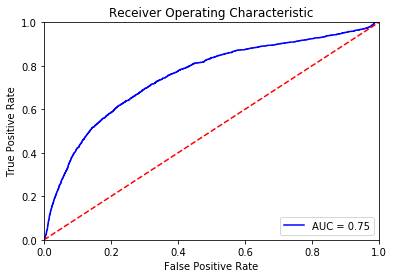

In [24]:
from sklearn.metrics import roc_curve, auc
df_clean['prediction_prob'] = model.predict_proba(preprocessing.transform(df_clean[features]))[:,1]

fpr, tpr, threshold = roc_curve(df_clean[label_clf], df_clean['prediction_prob'] )

roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

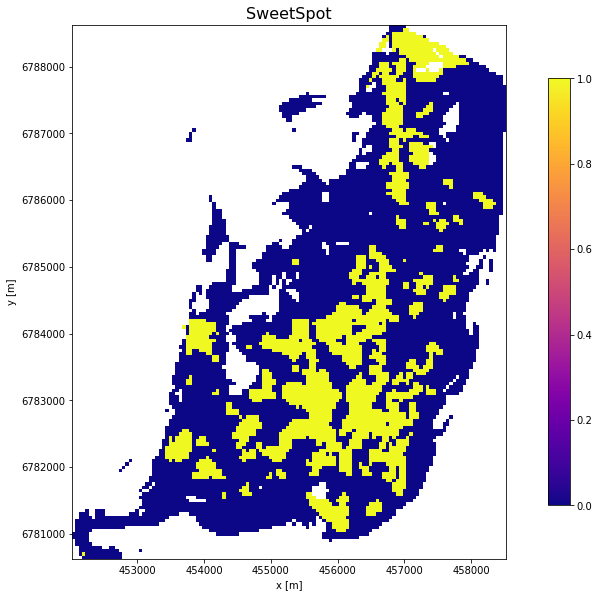

In [25]:
ssp.plot_map(df_clean, label_clf, dtype='cat')

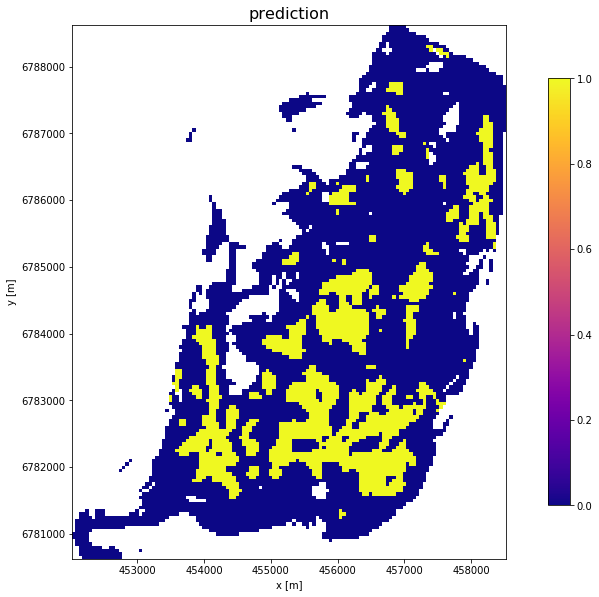

In [26]:
ssp.plot_map(df_clean, 'prediction', dtype='cat')

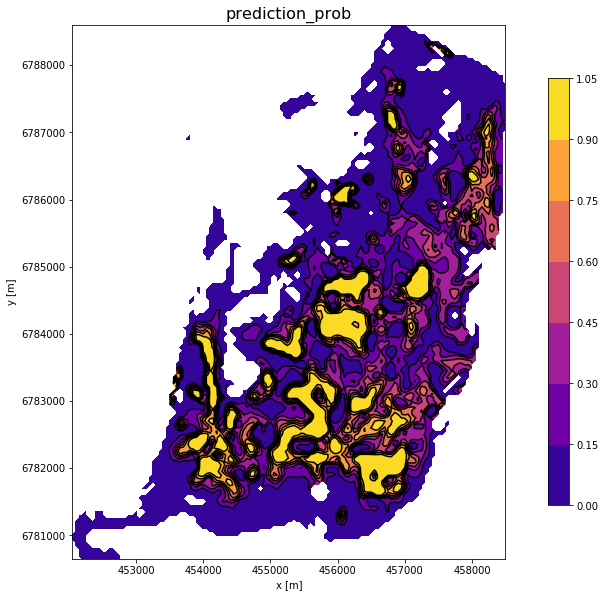

In [27]:
ssp.plot_map(df_clean, 'prediction_prob')